In [19]:
import tensorflow as tf
import tensorflow_probability as tfp
%matplotlib inline
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors
print("TF version:", tf.__version__)
print("TFP version:", tfp.__version__)

TF version: 2.7.0
TFP version: 0.15.0


## Maximising the ELBO 
We manipulate the ELBO as below to derive the VAE loss function
\begin{align}
\mathbb{E}_{z \sim q(z | x)} \big[ \log \frac{p(z,x)}{q(z|x)} \big] &=  \mathbb{E}_{z \sim q(z | x)} \big[ \log p(z,x) \big] - \mathbb{E}_{z \sim q(z | x)} \big[\log q(z|x)\big] \\
&=  \mathbb{E}_{z \sim q(z | x)} \big[ \log(p(x|z)p(z) )\big] - \mathbb{E}_{z \sim q(z | x)} \big[ \log q(z|x)\big] \\
&=  \mathbb{E}_{z \sim q(z | x)} \big[ \log p(x|z) \big] + \mathbb{E}_{z \sim q(z | x)} \big[\log p(z) \big] - \mathbb{E}_{z \sim q(z | x)} \big[\log  q(z|x)\big] \\
&=  \mathbb{E}_{z \sim q(z | x)} \big[ \log p(x|z) \big] - \mathbb{E}_{z \sim q(z | x)} \big[\log \frac{q(z|x)}{p(z)} \big] \\
&=  \mathbb{E}_{z \sim q(z | x)} \big[ \log p(x|z) \big] - \mathrm{KL}\big[ \ q(z | x) \ || \ p(z) \ \big] \\
\end{align}

Now we can define $q(z|x)$ as an encoding distribution, $p(x|z)$ as a decoding distribution, and $p(z)$ is the prior distribution.

In [20]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape
import matplotlib.pyplot as plt
import numpy as np

In [21]:
# Import Fasion MNIST, make it a TensorFlow Dataset

(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.
example_x = x_test[:16]

batch_size = 64
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)

In [22]:
# Define the encoding distribution, q(z|x)
latent_size = 2
event_shape = (28,28)

#MultivariateNormalDiag where we have zero covariances between variates.
#2-dimensinal MultivariateNormal
encoder = Sequential([
           Flatten(input_shape=event_shape),
           Dense(256, activation='relu'),
           Dense(128, activation='relu'),          
           Dense(64, activation='relu'),
           Dense(32, activation='relu'),
           Dense(2*latent_size),
           tfpl.DistributionLambda(
               lambda t: tfd.MultivariateNormalDiag(
                   loc=t[..., :latent_size],
                   scale_diag=tf.math.exp(t[...,latent_size:])
               )
           )

])


In [23]:
# Pass an example image through the network - should return a batch of MultivariateNormalDiags.
encoder(example_x)

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[16] event_shape=[2] dtype=float32>

In [24]:
# Define the decoding distribution, p(x|z)
# input is 2 dimensional, sampled from the 2 dimensional Gaussian (defined by the encoder)

decoder = Sequential([
          Dense(32, activation='relu'),
          Dense(64, activation='relu'),
          Dense(128, activation='relu'),
          Dense(256, activation='relu'),    
          Dense(tfpl.IndependentBernoulli.params_size(event_shape)),
          tfpl.IndependentBernoulli(event_shape)   
])


In [25]:
# Pass a batch of examples to the decoder
decoder(tf.random.normal([16, latent_size]))


<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[16] event_shape=[28, 28] dtype=float32>

In [26]:
# Define the prior, p(z) - a standard bivariate Gaussian
prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_size))


The loss function we need to estimate is

\begin{equation}
-\mathrm{ELBO} = \mathrm{KL}[ \ q(z|x) \ || \ p(z) \ ] - \mathrm{E}_{Z \sim q(z|x)}[\log p(x|Z)]\\
\end{equation}

where $x = (x_1, x_2, \ldots, x_n)$ refers to all observations, $z = (z_1, z_2, \ldots, z_n)$ refers to corresponding latent variables.

Assumed independence of examples implies that we can write this as

\begin{equation}
\sum_j \mathrm{KL}[ \ q(z_j|x_j) \ || \ p(z_j) \ ] - \mathrm{E}_{Z_j \sim q(z_j|x_j)}[\log p(x_j|Z_j)]
\end{equation}

In [27]:
# Specify the loss function, an estimate of the -ELBO
def loss(x, encoding_dist, sampled_decoding_dist, prior):
  return tf.reduce_sum(
      tfd.kl_divergence(encoding_dist, prior) - sampled_decoding_dist.log_prob(x)
  )


In [28]:
# Define a function that returns the loss and its gradients
@tf.function
def get_loss_and_grads(x):
  with tf.GradientTape() as tape:
    encoding_dist = encoder(x)
    sampled_z = encoding_dist.sample()
    sampled_decoding_dist = decoder(sampled_z)
    current_loss = loss(x, encoding_dist, sampled_decoding_dist, prior)
  grads = tape.gradient(current_loss,
              encoder.trainable_variables +
              decoder.trainable_variables )
  return current_loss, grads          
                       

In [29]:
# Compile and train the model

num_epochs = 5
opt = tf.keras.optimizers.Adam()
for i in range(num_epochs):
    for train_batch in x_train:
        current_loss, grads = get_loss_and_grads(train_batch)
        opt.apply_gradients(zip(grads, encoder.trainable_variables
                                       + decoder.trainable_variables))
        
    print('-ELBO after epoch {}: {:.0f}'.format(i+1, current_loss.numpy()))

-ELBO after epoch 1: 8974
-ELBO after epoch 2: 8873
-ELBO after epoch 3: 8773
-ELBO after epoch 4: 8796
-ELBO after epoch 5: 8809


In [30]:
# Connect encoder and decoder, compute a reconstruction
def vae(inputs):
  approx_posterior = encoder(inputs)
  decoding_dist = decoder(approx_posterior.sample())
  return decoding_dist.sample()
example_reconstruction = vae(example_x).numpy().squeeze()

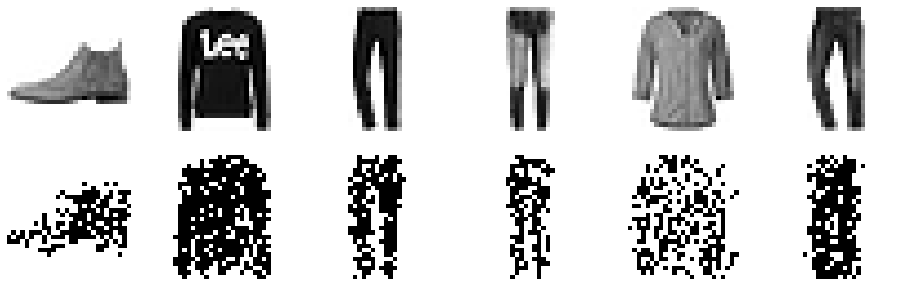

In [31]:
# Plot examples against reconstructions

f, axs = plt.subplots(2, 6, figsize=(16, 5))

for j in range(6):
    axs[0, j].imshow(example_x[j, :, :].squeeze(), cmap='binary')
    axs[1, j].imshow(example_reconstruction[j, :, :], cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')

In [32]:
# Generate an example - sample a z value, then sample a reconstruction from p(x|z)
z = prior.sample(6)
generated_x = decoder(z).mean()

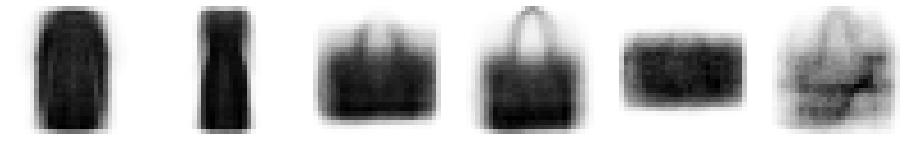

In [33]:
# Display generated_x
f, axs = plt.subplots(1, 6, figsize=(16, 5))
for j in range(6):
    axs[j].imshow(generated_x[j, :, :].numpy().squeeze(), cmap='binary')
    axs[j].axis('off')

In [34]:
def reconstruc_batch(input, k):
  approx_posterior = encoder(input)
  decoding_dist = decoder(approx_posterior.sample(k))
  return decoding_dist.sample()
#example_x contains 16 images.
#example_x[0,:,:] means the first image i.e., shoe
example = example_x[2,:,:] 
example = tf.expand_dims(example, 0)
#specify how many images you want to reconstruct
k = 6
example_reconstruction = reconstruc_batch(example, k).numpy().squeeze()

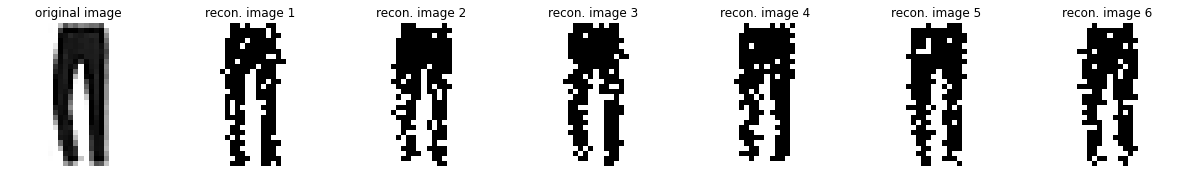

In [35]:
# Display reconstructed example
f, axs = plt.subplots(1, k+1, figsize=(3*(k+1), 5))
axs[0].imshow(example[0, :, :].numpy().squeeze(), cmap='binary')
axs[0].axis('off')
axs[0].set_title('original image')
for j in range(1,k+1):
  axs[j].imshow(example_reconstruction[j-1, :, :], cmap='binary')
  axs[j].axis('off')
  axs[j].set_title('recon. image '+str(j))

In [36]:
# # -ELBO estimate using an estimate of the KL divergence
# # Monte Carlo Approach 
# def loss_fn(x_true, approx_posterior, x_pred, prior_dist):
#     reconstruction_loss = -x_pred.log_prob(x_true)
#     approx_posterior_sample = approx_posterior.sample()
#     kl_approx = (approx_posterior.log_prob(approx_posterior_sample)


#                     - prior_dist.log_prob(approx_posterior_sample))
#     return tf.reduce_mean(kl_approx + reconstruction_loss)